# MAC0317/MAC5920
## Introdução ao Processamento de Sinais Digitais
## Seção 7.6: A Transformada Discreta Wavelet 2D e o padrão JPEG 2000

In [1]:
import math as m
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
import pywt
from urllib.request import urlopen
from IPython.display import display, Markdown
from ipywidgets import interactive, VBox, IntSlider, Layout

### Seção 7.7.1: Trasformadas Bidimensionais

Já vimos nos casos da DFT e da DCT como é simples criar transformadas 2D a partir de transformadas 1D:

> *basta transformar todas as linhas e depois todas as colunas da matriz, ou vice-versa (primeiro colunas e depois linhas).*

A transformada inversa seguirá o mesmo procedimento:

> *aplicar a transformada inversa em todas as linhas e depois em todas as colunas da matriz, ou vice-versa.*

No caso da Transformada Wavelet Discreta (DWT) representada pelas matrizes $W^a_N$ (análise em $\mathbb{C}^N$) e $W^s_N$ (síntese em $\mathbb{C}^N$), isso corresponde à definição abaixo:

#### Definição 7.7.1: Transformada Wavelet Discreta 2D

\begin{array}{ll}
\text{Análise:}&\mathcal{W}^a_{M\times N}(A) = W^a_MA(W^a_N)^T\\
\text{Síntese:}&\mathcal{W}^s_{M\times N}(\hat{A}) = W^s_M\hat{A}(W^s_N)^T.
\end{array}

**Observe** que $W^a_MW^s_M = I_{M\times M}$ e $W^a_NW^s_N = I_{N\times N}$, logo para qualquer imagem $A\in\mathcal{M}_{M\times N}(\mathbb{C})$ vale

$$\mathcal{W}^s_{M\times N}(\mathcal{W}^a_{M\times N}(A)) = W^s_MW^a_MA(W^a_N)^T(W^s_N)^T = A$$

(como já seria de se esperar).

### Estrutura da DWT 2D

Considerando que a aplicação da DWT separa cada linha e cada coluna em coeficientes de aproximação (primeira metade) e coeficientes de detalhes (segunda metade), podemos antecipar que a matriz $\hat{A} = \mathcal{W}^a_{M\times N}(A) = W^a_MA(W^a_N)^T$ será formada por 4 blocos:

$$\hat{A} = \begin{bmatrix}LL\text{ (aproximação)}&HL\text{ (detalhes vert.)} \\LH\text{ (detalhes horiz.)}&HH\text{ (detalhes diag.)}
\end{bmatrix},$$

onde as letras L=Low e H=High se referem aos filtros passa-baixas e passa-altas, considerando (por convenção) a aplicação da DWT primeiro nas linhas, depois nas colunas. Para enxugar a notação, usaremos as iniciais para indicar os coeficientes de **A**proximação, detalhes **V**erticais, detalhes **H**orizontais e detalhes **D**iagonais, todos de 1° nível:

$$\hat{A} = \begin{bmatrix}A_1&V_1 \\H_1&D_1
\end{bmatrix}.$$


In [2]:
# funções auxiliares

def rgb2gray(image):
    fil = [0.299, 0.587, 0.144]
    return np.dot(image, fil)

def distortion(x,l):                                                            
    return np.linalg.norm(x-l)/ np.linalg.norm(x)

# Carrega a imagem da internet e converte para nível de cinza\n"
url = "http://sutherncharm.files.wordpress.com/2009/09/double-ferris.jpg"
M = rgb2gray(imread(urlopen(url).read()))
#M = rgb2gray(imread("double_ferris.jpg"))[0:896,0:672]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  if sys.path[0] == "":


In [3]:
N = IntSlider(min=1, max=7, step=1, value=1, continuous_update=False, layout=Layout(width='95%'))
def plot_dwt2(etapa):
    fig, ax = plt.subplots(1, 2, figsize=(15,8))
    ax[0].imshow(M, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title(f"Imagem original")
    coefs = pywt.wavedec2(M, 'bior2.2', mode='zero', level=etapa)
    N, slices = pywt.coeffs_to_array(coefs)
    Nlog = np.log(1+abs(N))
    Nlog /= np.amax(Nlog)
    ax[1].imshow(Nlog, cmap='gray');
    ax[1].axis('off')
    ax[1].set_title(f"DWT (Le Gall 5/3) de {etapa} etapa(s)")
    plt.show()

#### <p style="text-align: center;">Exemplo 7.10, Figura 7.16</p>

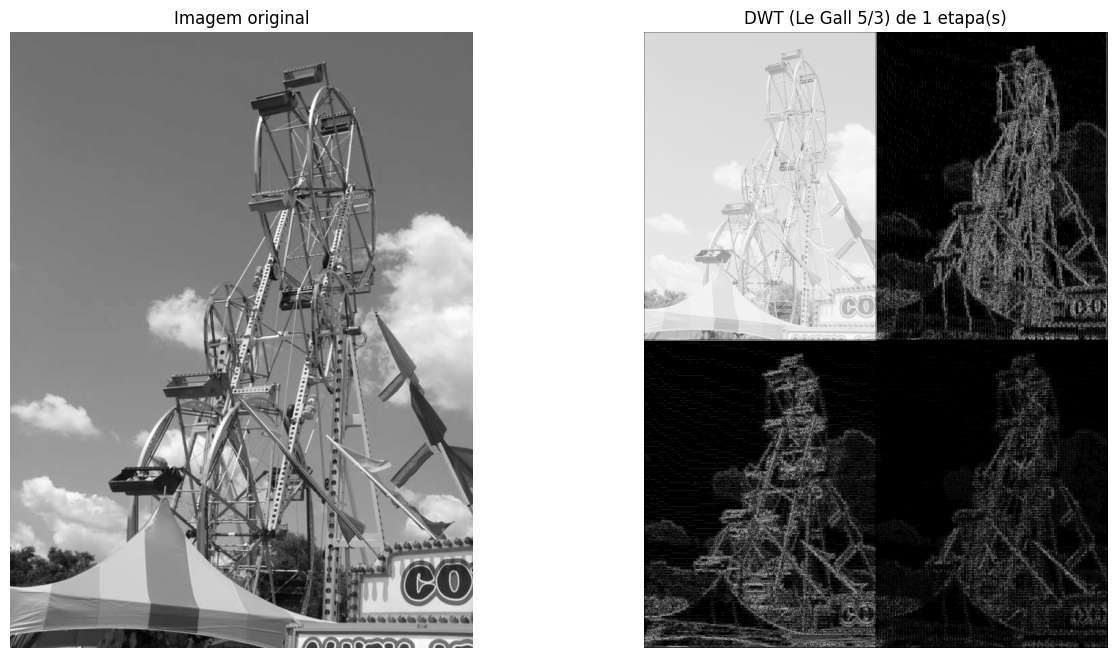

In [4]:
display(Markdown('#### <p style="text-align: center;">Exemplo 7.10, Figura 7.16</p>'))
plot_dwt2(1)

### Seção 7.7.2: Transformada DWT 2D Multi-Estágios

Na definição 7.7.1 não faz nenhuma diferença quais são as matrizes utilizadas para as transformadas direta e inversa, contanto que as matrizes de síntese sejam de fato as inversas das matrizes de análise. Assim, a definição da transformada em $r$ estágios é simplesmente:

#### Definição 7.7.2

\begin{array}{ll}
\text{Análise:}&\mathcal{W}^{a,(r)}_{M\times N}(A) = W^{a,(r)}_MA(W^{a,(r)}_N)^T\\
\text{Síntese:}&\mathcal{W}^{s,(r)}_{M\times N}(\hat{A}) = W^{s,(r)}_M\hat{A}(W^{s,(r)}_N)^T.
\end{array}

**Observação 7.3:** em análise de imagens é comum chegar-se a $r=4$ ou $5$ níveis, mas em teoria é possível aprofundar a análise até um máximo de $r=\lfloor\log_2(\min\{M,N\})\rfloor$.

Analogamente ao que observamos na transformada unidimensional, cada novo estágio aprofunda a análise apenas nos coeficientes de aproximação do estágio anterior, subdividindo-os em novos coeficientes de aproximação, detalhes horizontais, detalhes verticais e detalhes diagonais. Assim uma transformada em 2 estágios terá a estrutura:

$$\mathcal{W}^{a,(2)}_{M\times N}(A) = 
\begin{bmatrix}\begin{bmatrix}A_2&V_2 \\H_2&D_2
\end{bmatrix}&V_1 \\H_1&D_1
\end{bmatrix},$$

onde 

\begin{array}{lll}
A_2\text{=aprox 2° nível}&
V_2\text{=det. vert. 2° nível}&
V_1\text{=det. vert. 1° nível}\\
H_2\text{=det. hor. 2° nível}&
D_2\text{=det. diag. 2° nível}\\
H_1\text{=det. hor. 1° nível}&&
D_1\text{=det. diag. 1° nível.}
\end{array}


No caso de 3 níveis, teremos:

$$\mathcal{W}^{a,(3)}_{M\times N}(A) = 
\begin{bmatrix}\begin{bmatrix}\begin{bmatrix}A_3&V_3 \\H_3&D_3
\end{bmatrix}&V_2 \\H_2&D_2
\end{bmatrix}&V_1 \\H_1&D_1
\end{bmatrix}.$$

A generalização para $r$ níveis segue o mesmo padrão, sendo que no nível $r$ teremos um único bloco $A_r$ de coeficientes de aproximação e $3r$ blocos da forma $V_n$, $H_n$ e $D_n$ para os coeficientes de detalhes verticais, horizontais e diagonais dos níveis $n=1,2,\ldots,r$.

In [5]:
display(Markdown('#### <p style="text-align: center;">Figura 7.17</p>'))
w = interactive(plot_dwt2, etapa=N)
display(VBox([w.children[0], w.children[1]], layout=Layout(align_items='center')));w.update()

#### <p style="text-align: center;">Figura 7.17</p>

### Seção 7.7.3: Aproximação e detalhes para imagens

Assim como no caso unidimensional, é possível considerar reconstruções da imagem a partir de cada pedaço de uma DWT. Por exemplo, para o 1° nível:

$$\mathcal{W}^{a}_{M\times N}(A) = \begin{bmatrix}A_1&V_1 \\H_1&D_1
\end{bmatrix},$$

temos 

$$\begin{array}{ll}
A = &\mathcal{W}^{s}_{M\times N}\left(\begin{bmatrix}A_1&V_1 \\H_1&D_1
\end{bmatrix}\right)\\
&= \mathcal{W}^{s}_{M\times N}\left(\begin{bmatrix}A_1&0 \\0&0
\end{bmatrix}\right) + \mathcal{W}^{s}_{M\times N}\left(\begin{bmatrix}0&V_1 \\H_1&D_1
\end{bmatrix}\right)\\
&=\alpha_1(A)+\delta_1(A),\end{array}$$

onde $\alpha_1(A)\in\mathcal{M}_{M\times N}(\mathbb{C})$ é a reconstrução a partir dos coeficientes de aproximação de nível 1, e $\delta_1(A)$ é a reconstrução a partir de todos os coeficientes de detalhes de nível 1.

No caso da transformada em 2 estágios:

$$\mathcal{W}^{a,(2)}_{M\times N}(A) = 
\begin{bmatrix}\begin{bmatrix}A_2&V_2 \\H_2&D_2
\end{bmatrix}&V_1 \\H_1&D_1
\end{bmatrix},$$

podemos escrever

$$\begin{array}{ll}
A&=\mathcal{W}^{s,(2)}_{M\times N}
\left(\begin{bmatrix}\begin{bmatrix}A_2&V_2 \\H_2&D_2
\end{bmatrix}&V_1 \\H_1&D_1
\end{bmatrix}\right)\\
&=\mathcal{W}^{s,(2)}_{M\times N}
\left(\begin{bmatrix}\begin{bmatrix}A_2&0 \\0&0
\end{bmatrix}&0 \\0&0
\end{bmatrix}\right)
+\mathcal{W}^{s,(2)}_{M\times N}
\left(\begin{bmatrix}\begin{bmatrix}0&V_2 \\H_2&D_2
\end{bmatrix}&0 \\0&0
\end{bmatrix}\right)
+\mathcal{W}^{s,(2)}_{M\times N}
\left(\begin{bmatrix}\begin{bmatrix}0&0 \\0&0
\end{bmatrix}&V_1 \\H_1&D_1
\end{bmatrix}\right)\\
&=\alpha_2(A)+\delta_2(A)+\delta_1(A).
\end{array}$$

In [6]:
N = IntSlider(min=1, max=7, step=1, value=1, continuous_update=False, layout=Layout(width='95%'))
def plot_dwt2_compression(etapa):
    fig, ax = plt.subplots(1, 2, figsize=(15,7))
    ax[0].imshow(M, cmap='gray')
    ax[0].set_title("Imagem original")
    coefs = pywt.wavedec2(M, 'bior2.2', mode='zero', level=etapa)
    for i in range(1, len(coefs)):
        coefs[i] = tuple([np.zeros_like(v) for v in coefs[i]])
    N = pywt.waverec2(coefs, 'bior2.2', mode='zero')
    ax[1].imshow(N, cmap='gray')
    ax[1].set_title(f"Reconstrucao a partir da etapa {etapa}:\n erro = {100*distortion(M, N):2.2f}%, tamanho = {100*(1/4)**etapa:2.1f}%")
    plt.show()

In [7]:
display(Markdown('#### <p style="text-align: center;">Figuras 7.18 e 7.19</p>'))
w = interactive(plot_dwt2_compression, etapa=N)
display(VBox([w.children[0], w.children[1]], layout=Layout(align_items='center')));w.update()

#### <p style="text-align: center;">Figuras 7.18 e 7.19</p>

### Seção 7.7.4: O padrão JPEG 2000

O objetivo dessa seção é apenas indicar os passos do padrão JPEG 2000:

1. Separação em componentes de cor R, G e B
2. Subtração da componente d.c.
3. Segmentação em blocos (como na seção 3.7)
4. DWT (usando Daubechies 9/7 ou Le Gall 5/3)
5. Quantização (como na seção 3.8)
7. Compressão (codificação baseada em entropia)